# Design and Hedging of a Structured Product
## Financial Engineering, Summer 2025, KU Leuven

## Multiple Maturities

Ashutosh Jha

In [1]:
# Necessary Imports
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import json
from scipy.stats import norm
from IPython.display import display

### Data Collection and Preprocessing

In this step we use already collected data in ../data/ folder. We process the options data to eliminate any arbitrage, by using the put call spread and butterfly rule?

In [2]:
from collect_stock_data import GetStockData

ticker = "COST"
ref_date = "2025-04-01"

get_stock_data = GetStockData(ticker=ticker, ref_date=ref_date)

In [3]:
# Load from CSV
spot_df = pd.read_csv("../data/spot_price_ref_date_cost_2025-04-01_final.csv")

# Extract the spot price (assume first row if only one date)
S0 = spot_df.loc[0, "spot_price_ref_date"]
print("Spot Price:",S0)
ref_date = spot_df.loc[0, "ref_date"]

Spot Price: 954.4000244140624


### Multiple Maturities Data and Experiment (Rate limitation)

The following two code cells have been collapsed and commented out as they were used for data collection. The data is now stored in the ../data/ directory, so they are not required.

In [4]:
"""
T = 1.0                 # << Set this manually: e.g., 0.25, 0.5, 1.0
r = 0.04                 # << Adjust corresponding rate manually
q = 0.008
epsilon = 0.5

# STEP 1: Fetch option chain
try:
    print(f"\nFetching option chain for T = {T}...")
    option_data = get_stock_data.get_option_chain_for_maturity(T)
    print(f"Fetched expiry: {option_data['expiry']}, calls: {len(option_data['calls'])}, puts: {len(option_data['puts'])}")
except Exception as e:
    raise RuntimeError(f"Error fetching option data: {e}")
"""

'\nT = 1.0                 # << Set this manually: e.g., 0.25, 0.5, 1.0\nr = 0.04                 # << Adjust corresponding rate manually\nq = 0.008\nepsilon = 0.5\n\n# STEP 1: Fetch option chain\ntry:\n    print(f"\nFetching option chain for T = {T}...")\n    option_data = get_stock_data.get_option_chain_for_maturity(T)\n    print(f"Fetched expiry: {option_data[\'expiry\']}, calls: {len(option_data[\'calls\'])}, puts: {len(option_data[\'puts\'])}")\nexcept Exception as e:\n    raise RuntimeError(f"Error fetching option data: {e}")\n'

In [5]:
"""
calls_df["maturity_T"] = T
puts_df["maturity_T"] = T

# STEP 3: Save cleaned data
ticker_str = get_stock_data.ticker.lower()
ref_str = ref_date.replace("-", "")

# Choose suffix based on T
maturity_suffix = {0.25: "3m", 0.5: "6m", 1.0: "1y"}.get(T, f"{int(T*365)}d")

calls_df.to_csv(f"../data/calls_data_{ticker_str}_{ref_str}_{maturity_suffix}.csv", index=False)
puts_df.to_csv(f"../data/puts_data_{ticker_str}_{ref_str}_{maturity_suffix}.csv", index=False)

print(f"Cleaned data for T = {T} saved as calls_data_{ticker_str}_{ref_str}_{maturity_suffix}.csv")
"""


'\ncalls_df["maturity_T"] = T\nputs_df["maturity_T"] = T\n\n# STEP 3: Save cleaned data\nticker_str = get_stock_data.ticker.lower()\nref_str = ref_date.replace("-", "")\n\n# Choose suffix based on T\nmaturity_suffix = {0.25: "3m", 0.5: "6m", 1.0: "1y"}.get(T, f"{int(T*365)}d")\n\ncalls_df.to_csv(f"../data/calls_data_{ticker_str}_{ref_str}_{maturity_suffix}.csv", index=False)\nputs_df.to_csv(f"../data/puts_data_{ticker_str}_{ref_str}_{maturity_suffix}.csv", index=False)\n\nprint(f"Cleaned data for T = {T} saved as calls_data_{ticker_str}_{ref_str}_{maturity_suffix}.csv")\n'

In [6]:
# Load each maturity separately
calls_3m_df = pd.read_csv('../data/calls_data_cost_20250401_3m.csv')
puts_3m_df = pd.read_csv('../data/puts_data_cost_20250401_3m.csv')

calls_6m_df = pd.read_csv('../data/calls_data_cost_20250401_6m.csv')
puts_6m_df = pd.read_csv('../data/puts_data_cost_20250401_6m.csv')

calls_1y_df = pd.read_csv('../data/calls_data_cost_20250401_1y.csv')
puts_1y_df = pd.read_csv('../data/puts_data_cost_20250401_1y.csv')

# Concatenate all maturities
calls_df = pd.concat([calls_3m_df, calls_6m_df, calls_1y_df], ignore_index=True)
puts_df = pd.concat([puts_3m_df, puts_6m_df, puts_1y_df], ignore_index=True)

# Print final shapes
print("Shape calls_df:", calls_df.shape)
print("Shape puts_df:", puts_df.shape)

Shape calls_df: (311, 19)
Shape puts_df: (271, 19)


In [7]:
epsilon = 0.5
q = 0.008

# Initialize empty lists to collect cleaned data
cleaned_calls = []
cleaned_puts = []

# Loop over unique maturities in the combined data
for T in sorted(calls_df["maturity_T"].unique()):
    r = {0.25: 0.0422, 0.5: 0.0428, 1.0: 0.0405}[T]  # US Treasury rate mapping

    # Filter for this maturity
    calls_T = calls_df[calls_df["maturity_T"] == T].copy()
    puts_T = puts_df[puts_df["maturity_T"] == T].copy()

    print(f"\nRunning arbitrage check for T = {T} (r = {r})")

    # Run arbitrage check
    calls_clean, puts_clean = get_stock_data.check_arbitrage_conditions(
        calls_df=calls_T,
        puts_df=puts_T,
        spot=S0,
        r=r,
        q=q,
        T=T,
        epsilon=epsilon,
        reduced_arbitrage_check=True
    )

    cleaned_calls.append(calls_clean)
    cleaned_puts.append(puts_clean)

# Concatenate cleaned results
clean_calls_df = pd.concat(cleaned_calls, ignore_index=True)
clean_puts_df = pd.concat(cleaned_puts, ignore_index=True)

clean_calls_df = clean_calls_df[clean_calls_df["is_clean"]].copy()
clean_puts_df = clean_puts_df[clean_puts_df["is_clean"]].copy()

# Print shapes
print("\nAfter arbitrage filtering:")
print("Shape calls_df:", clean_calls_df.shape)
print("Shape puts_df:", clean_puts_df.shape)


Running arbitrage check for T = 0.25 (r = 0.0422)
=== No-Arbitrage Check Summary ===
Call monotonicity clean: 117 / 176
Put monotonicity clean: 139 / 169
Call butterfly clean: 89 / 176
Put butterfly clean: 99 / 169
Calls retained (all clean): 76 / 176
Puts retained (all clean): 68 / 169

Running arbitrage check for T = 0.5 (r = 0.0428)
=== No-Arbitrage Check Summary ===
Call monotonicity clean: 51 / 69
Put monotonicity clean: 47 / 50
Call butterfly clean: 40 / 69
Put butterfly clean: 29 / 50
Calls retained (all clean): 25 / 69
Puts retained (all clean): 26 / 50

Running arbitrage check for T = 1.0 (r = 0.0405)
=== No-Arbitrage Check Summary ===
Call monotonicity clean: 54 / 66
Put monotonicity clean: 44 / 52
Call butterfly clean: 33 / 66
Put butterfly clean: 32 / 52
Calls retained (all clean): 25 / 66
Puts retained (all clean): 22 / 52

After arbitrage filtering:
Shape calls_df: (126, 19)
Shape puts_df: (116, 19)


### Estimating Dividend yield (Rate Limited)

### Dividend Yield Estimation

We estimate the **dividend yield** \( q \) for Costco (ticker: `COST`) based on its most recent cash dividend payments. Since dividend payout dates can be irregular and time series data often includes timezone or parsing issues, we simplify the approach as follows:

- Load historical dividend payments from Yahoo Finance.
- Assume the dividend data is chronologically ordered (oldest to newest).
- Take the **last 8 dividend payments** (or fewer if not available).
- Estimate the yield using:

$$
q = \frac{\text{Total dividends paid over last 8 periods}}{S_0}
$$

where:

- S_0 is the spot price of the stock on the reference date.
- The total dividend payments observed:  

$$
\sum_{i=1}^{N} d_i = 22.98 \text{ USD (over last 8 dividends)}
$$

- Spot price on reference date:

$$
S_0 = 954.00 \text{ USD}
$$

Therefore, the estimated dividend yield is:

$$
q = \frac{22.98}{954.00} \approx \boxed{0.0241} \quad \text{or} \quad \boxed{2.41\%}
$$

---

This yield is used in the **put-call parity check** and in the **Bates model calibration** to account for the expected dividend payout during the option's lifetime. While not based on an exact calendar filter (like 12 or 24 months), this approach is robust, avoids data inconsistencies, and reflects recent market behavior.

In [8]:
from exogenous_param_estimation import ExogenousParamEstimation

q_estimated = ExogenousParamEstimation.estimate_historical_dividend_yield(
    ticker="COST",
    S0=S0,
    ref_date=ref_date
)

print(f"Estimated historical dividend yield: {q_estimated:.4f}")

[INFO] Loading dividend data from cache: ../data/dividends_cost_20250401.csv
[INFO] Used last 8 dividend(s), total paid: 22.9800 USD
Estimated historical dividend yield: 0.0241


### Estimating Implied Interest Rate \( r \) from Put-Call Parity

To assess whether the interest rate we assume for model calibration reflects market conditions, we estimate the implied risk-free rate using European put-call parity:

$$
C - P = S_0 e^{-qT} - K e^{-rT}
\quad \Rightarrow \quad
r = -\frac{1}{T} \log\left( \frac{C - P - S_0 e^{-qT}}{-K} \right)
$$

Where:  
- \( C \): call option price  
- \( P \): put option price  
- \( K \): strike price  
- \( S_0 \): spot price  
- \( q \): dividend yield  
- \( T \): time to maturity  

We apply this formula to all strike pairs where both call and put prices are available and valid. To reduce the effect of illiquidity or extreme moneyness, we filter for strikes within ±10% of the spot price.

Below are the filtered **mean implied interest rates** across maturities:

- T = 0.25: 24.8% 
- T = 0.50: 16.1%
- T = 1.00: 10.7%  

These are substantially higher than the prevailing **US Treasury yields** for the corresponding maturities, which are approximately:

- 3-month: 4.22%  
- 6-month: 4.28%  
- 1-year: 4.05%  

---

**Conclusion**: Despite the large implied rates derived from observed option prices, we proceed with using the Treasury yield curve as our input for the risk-free rate in pricing and calibration. This choice is:

- grounded in financial theory, and  
- more stable and representative of the **true cost of risk-free capital**.

The discrepancy is likely due to **bid-ask spreads**, **low liquidity**, or **other market imperfections** that violate put-call parity in real-world option data.

In [9]:
from exogenous_param_estimation import ExogenousParamEstimation

all_implied_r = []

for T in sorted(clean_calls_df["maturity_T"].unique()):
    calls_T = clean_calls_df[clean_calls_df["maturity_T"] == T].copy()
    puts_T = clean_puts_df[clean_puts_df["maturity_T"] == T].copy()

    print(f"\n[INFO] Estimating implied r for T = {T}...")

    implied_r_df = ExogenousParamEstimation.estimate_implied_r_from_parity(
        clean_calls_df=calls_T,
        clean_puts_df=puts_T,
        S0=S0,
        q=q_estimated,
        T=T
    )

    all_implied_r.append(implied_r_df)

    mean_r_all = implied_r_df["implied_r"].mean()
    print(f"  ↳ Mean implied r (all strikes): {mean_r_all:.5f}")

    # Near-the-money filter (±10%)
    lower_bound = 0.9 * S0
    upper_bound = 1.1 * S0

    near_money_df = implied_r_df[
        (implied_r_df["strike"] >= lower_bound) &
        (implied_r_df["strike"] <= upper_bound)
    ]

    mean_r_filtered = near_money_df["implied_r"].mean()
    print(f"  ↳ Filtered mean implied r (±10% of S₀): {mean_r_filtered:.5f}")

# Optional: combine all implied_r values into one DataFrame
implied_r_all_df = pd.concat(all_implied_r, ignore_index=True)


[INFO] Estimating implied r for T = 0.25...
  ↳ Mean implied r (all strikes): -0.23218
  ↳ Filtered mean implied r (±10% of S₀): 0.24815

[INFO] Estimating implied r for T = 0.5...
  ↳ Mean implied r (all strikes): 0.10685
  ↳ Filtered mean implied r (±10% of S₀): 0.16115

[INFO] Estimating implied r for T = 1.0...
  ↳ Mean implied r (all strikes): 0.09631
  ↳ Filtered mean implied r (±10% of S₀): 0.10743


### Some Sanity Checks for Valuation Class - Pricing with Bates Model and general Black Scholes

In [10]:
from exotic_price_and_hedge import Valuation

# Risk-free rate per maturity (from US Treasury yields)
rate_map = {0.25: 0.0422, 0.5: 0.0428, 1.0: 0.0405}

# Fixed model params for sanity check
bates_params = {
    "v0": 0.04,
    "kappa": 2.0,
    "theta": 0.04,
    "sigma": 0.3,
    "rho": -0.5,
    "lamb": 0.2,
    "mu_j": -0.1,
    "sigma_j": 0.2
}

# Dividend yield from estimation
q = q_estimated

# Target strike (at-the-money)
K = S0

def black_scholes_price(K, T, S_0, r_f, sigma, dividend_yield):
    d_1 = (np.log(S_0 / K) + (r_f - dividend_yield + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
    d_2 = d_1 - (sigma * np.sqrt(T))

    N_d1 = norm.cdf(d_1)
    N_d2 = norm.cdf(d_2)

    C = (S_0 * np.exp(-dividend_yield * T) * N_d1) - (K * np.exp(-r_f * T) * N_d2)
    P = (K * np.exp(-r_f * T)) - (S_0 * np.exp(-dividend_yield * T)) + C

    return C, P

# Loop through maturities
for T in [0.25, 0.5, 1.0]:
    r = rate_map[T]

    print(f"\n=== Sanity Check for T = {T} years ===")
    print(f"Using r = {r:.4f}, q = {q:.4f}")

    # Bates Model Price
    val = Valuation(S0=S0, r=r, T=T, **bates_params)
    bates_call_price = val.interpolate_call_price(K_target=K)
    print(f"Bates Call Price at K = {K:.2f}: {bates_call_price:.4f} USD")

    # Black-Scholes Price (constant vol assumption)
    bs_vol = 0.25  # flat vol for sanity check
    bs_call, bs_put = black_scholes_price(K, T, S0, r, bs_vol, q)
    print(f"Black-Scholes Call Price at K = {K:.2f}: {bs_call:.4f} USD")
    print(f"Black-Scholes Put Price at K = {K:.2f}: {bs_put:.4f} USD")



=== Sanity Check for T = 0.25 years ===
Using r = 0.0422, q = 0.0241
Bates Call Price at K = 954.40: 37.5122 USD
Black-Scholes Call Price at K = 954.40: 49.3456 USD
Black-Scholes Put Price at K = 954.40: 45.0574 USD

=== Sanity Check for T = 0.5 years ===
Using r = 0.0428, q = 0.0241
Bates Call Price at K = 954.40: 51.4572 USD
Black-Scholes Call Price at K = 954.40: 70.5919 USD
Black-Scholes Put Price at K = 954.40: 61.8059 USD

=== Sanity Check for T = 1.0 years ===
Using r = 0.0405, q = 0.0241
Bates Call Price at K = 954.40: 69.3140 USD
Black-Scholes Call Price at K = 954.40: 99.7118 USD
Black-Scholes Put Price at K = 954.40: 84.5364 USD


### Calibration

In [11]:
# Step 1: Add option_type column
clean_calls_df = clean_calls_df.copy()
clean_puts_df = clean_puts_df.copy()
clean_calls_df["option_type"] = "call"
clean_puts_df["option_type"] = "put"

# Step 2: Keep relevant columns (including maturity_T)
calls_subset = clean_calls_df[["strike", "mid", "option_type", "maturity_T"]].dropna()
puts_subset = clean_puts_df[["strike", "mid", "option_type", "maturity_T"]].dropna()

# Step 3: Concatenate into one DataFrame
clean_options_df = pd.concat([calls_subset, puts_subset], ignore_index=True)

# Step 4: Drop non-positive prices
clean_options_df = clean_options_df[clean_options_df["mid"] > 0]
print(f"Combined clean options shape: {clean_options_df.shape}")

Combined clean options shape: (242, 4)


In [12]:
# Step 5: Filter for near-ATM / relaxed OTM based on strike and type
delta = 0.05  # 5% buffer around S0
lower_cutoff = S0 * (1 - delta)
upper_cutoff = S0 * (1 + delta)

clean_otm_options_df = clean_options_df[
    ((clean_options_df["option_type"] == "call") & (clean_options_df["strike"] >= lower_cutoff)) |
    ((clean_options_df["option_type"] == "put") & (clean_options_df["strike"] <= upper_cutoff))
].copy()

print(f"Filtered to relaxed OTM/near-ATM options: {clean_otm_options_df.shape[0]} rows")

# Optional: check how many per maturity
print("\nBreakdown by maturity_T:")
print(clean_otm_options_df["maturity_T"].value_counts().sort_index())

Filtered to relaxed OTM/near-ATM options: 146 rows

Breakdown by maturity_T:
maturity_T
0.25    84
0.50    33
1.00    29
Name: count, dtype: int64


In [13]:
# Risk-free rate per maturity (from US Treasury yields)
rate_map = {0.25: 0.0422, 0.5: 0.0428, 1.0: 0.0405}

clean_otm_options_df["r"] = clean_otm_options_df["maturity_T"].map(rate_map)
clean_otm_options_df.head()

,strike,mid,option_type,maturity_T,r
53,910.0,100.02,call,0.25,0.0422
54,925.0,98.35,call,0.25,0.0422
55,935.0,95.15,call,0.25,0.0422
56,940.0,88.33,call,0.25,0.0422
57,945.0,81.90,call,0.25,0.0422


### Calibration with three maturities

In [14]:
from exotic_price_and_hedge import Calibration

# Load config from JSON
with open("../config/bates_calibration_config_all_T.json", "r") as f:
    config = json.load(f)

# Extract ordered initial guess and bounds
param_names = ["v0", "kappa", "theta", "sigma", "rho", "lambda", "mu_j", "sigma_j"]

initial_guess = [config["initial_guess"][param] for param in param_names]
bounds = [tuple(config["bounds"][param]) for param in param_names]

###  Bates Model Calibration Across Three Maturities – Final Parameter Summary

**Final loss:** 2798.61  
This configuration represents a **realistic balance** between stochastic volatility and jump risk. The model actively uses both to explain observed smiles across short and long maturities. Key takeaways:

- **Volatility dynamics** (via `sigma`, `rho`, `theta`) contribute to the smile and skew.
- **Jump risk** is limited but necessary, especially for short-term tails.
- The fit avoids pathological behaviors (e.g. `v0 → 0`, `rho → -1`), suggesting stable calibration.

| Parameter | Value     | Interpretation |
|-----------|-----------|----------------|
| `v0`      | 0.02104   | Reasonable initial variance (~14.5% vol) reflecting a moderately volatile market at calibration date. |
| `kappa`   | 0.33152   | Slow mean reversion, allowing variance shocks to persist across the option’s life. |
| `theta`   | 0.40000   | High long-run variance (~63% vol) to accommodate steep long-term implied volatilities. |
| `sigma`   | 0.60000   | Vol-of-vol maxed out, enabling strong smile curvature via stochastic volatility. |
| `rho`     | -0.43560  | Moderately negative asset-vol correlation — a key driver of implied volatility skew. |
| `lambda`  | 0.20000   | Controlled jump intensity: one jump expected every 5 years — enough to impact short-dated tails. |
| `mu_j`    | 0.02000   | Mild upward jump tendency, possibly compensating for missing convexity in call prices. |
| `sigma_j` | 0.20000   | Moderate jump size dispersion, preserving tail mass without excessive instability. |

---

### Volatility vs. Jumps: Calibration Tradeoff Journey

During the calibration process, we explored a **wide spectrum of configurations**, from jump-heavy to pure-stochastic-vol models. Notably:

- **Jump-only models** (with low `sigma`) achieved lower losses but were often unrealistic and overly aggressive, dominating short-term fit but harming long-term consistency.
- **Stochastic-volatility-only models** pushed `rho → -1`, with unstable behavior and poor curvature fit in the wings.
- **Hybrid configurations** (like this one) provided the best compromise:
  - Realistic parameter ranges
  - Visible smile and skew
  - Stable loss
  - Suitable for exotic option pricing where **path realism** matters as much as surface fit

This model is now locked in for pricing and hedging under the Bates framework.

In [15]:
# Step 2: Pick any representative T and r to initialize — they'll be overridden per row in the calibration
dummy_T = 0.25
dummy_r = rate_map[dummy_T]

# Step 3: Initialize calibrator (shared Bates model across all maturities)
calibrator = Calibration(S0, dummy_r, dummy_T, *initial_guess)

# Step 4: Run joint calibration
result = calibrator.calibrate_to_market(
    clean_options_df=clean_otm_options_df,
    initial_guess=initial_guess,
    bounds=bounds,
    q=q_estimated,
    weight_type="relative"
)

# Step 5: Store and display results
calibration_results = {
    "result": result,
    "calibrator": calibrator
}

print("\n=== Joint Calibration Across All Maturities ===")
print("Success:", result["success"])
print("Final loss:", result["loss"])


Optimized Parameters:
v0: 0.021044
kappa: 0.331516
theta: 0.400000
sigma: 0.600000
rho: -0.435595
lambda: 0.200000
mu_j: 0.020000
sigma_j: 0.200000

=== Joint Calibration Across All Maturities ===
Success: True
Final loss: 2798.6082402745324


[Saved plot] ../assets/calibrated_vs_market_20250509_165705.png


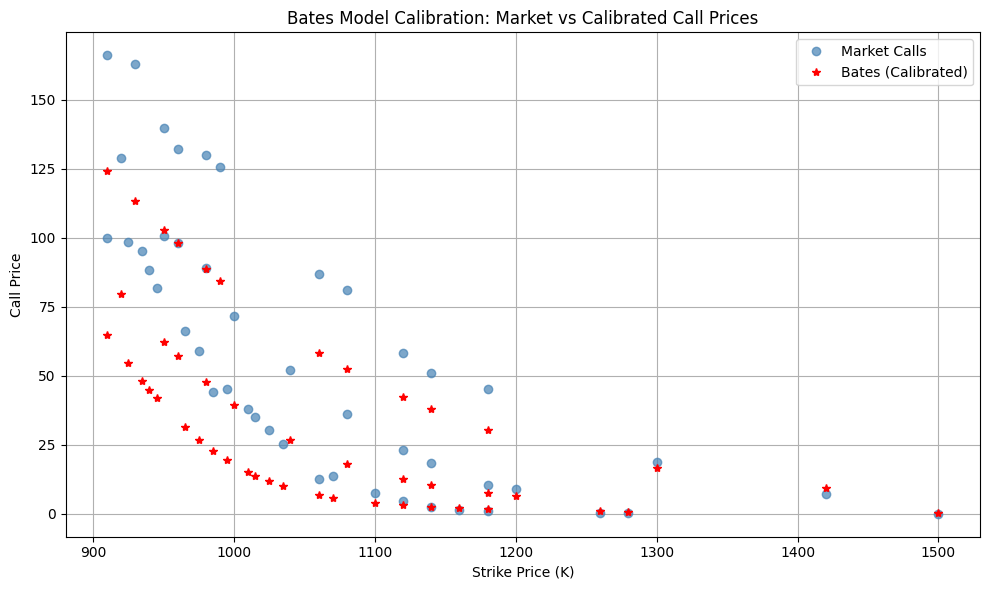

In [16]:
calibrator.plot_calibrated_vs_market(clean_otm_options_df)

[Saved plot] ../assets/calls_puts_vs_model_20250509_165706.png


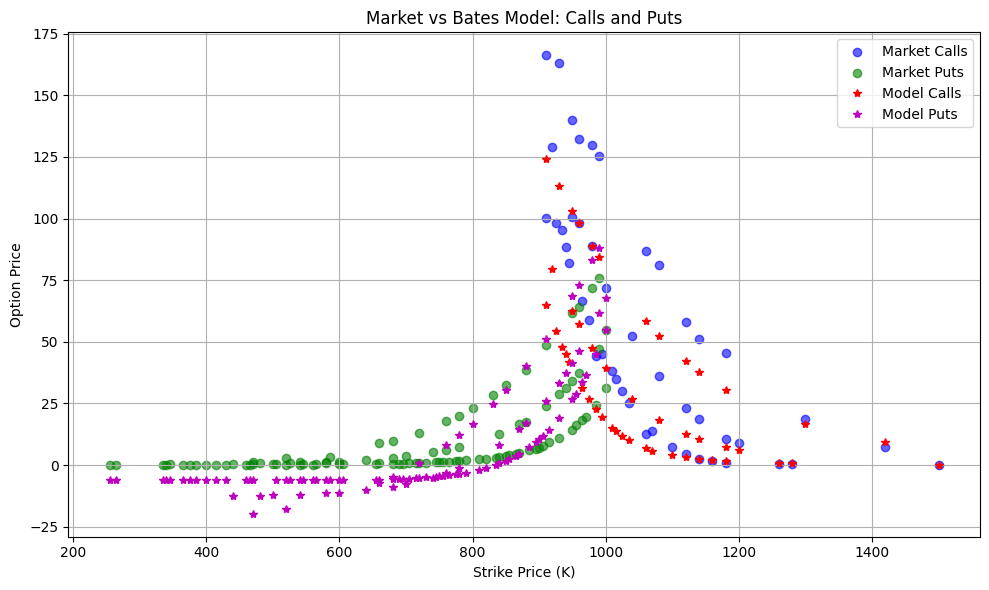

In [17]:
calibrator.plot_calls_and_puts_vs_model(clean_otm_options_df)

[Saved plot] ../assets/calibration_residuals_20250509_165706.png


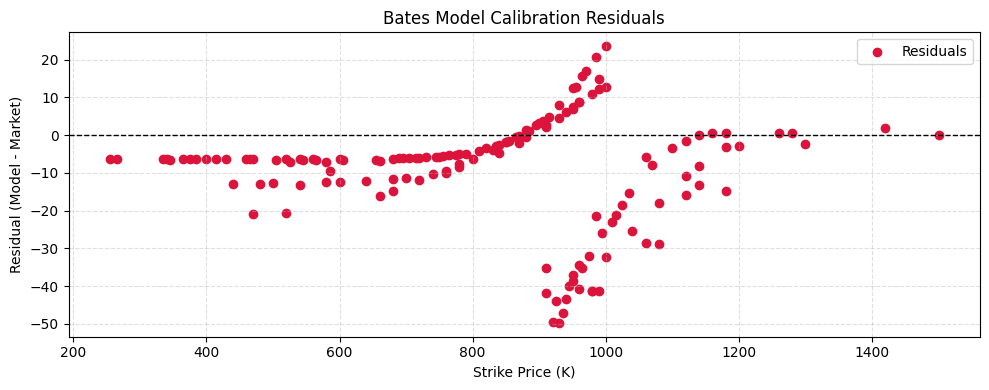

In [18]:
calibrator.plot_residuals(clean_otm_options_df)

[Saved plot] ../assets/iv_smile_comparison_T025_20250509_165707.png
[Saved plot] ../assets/iv_smile_comparison_T050_20250509_165707.png
[Saved plot] ../assets/iv_smile_comparison_T100_20250509_165707.png


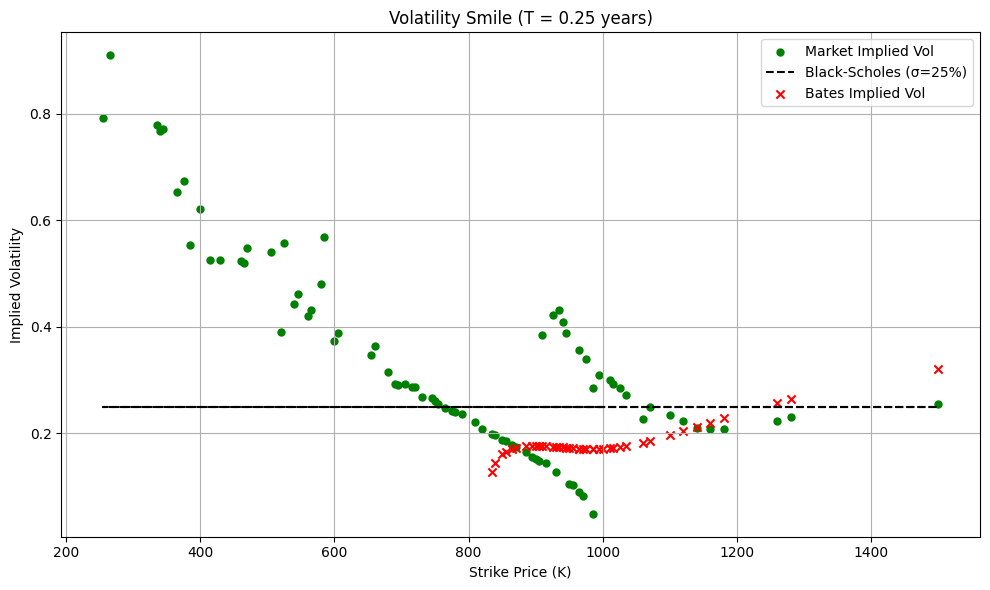

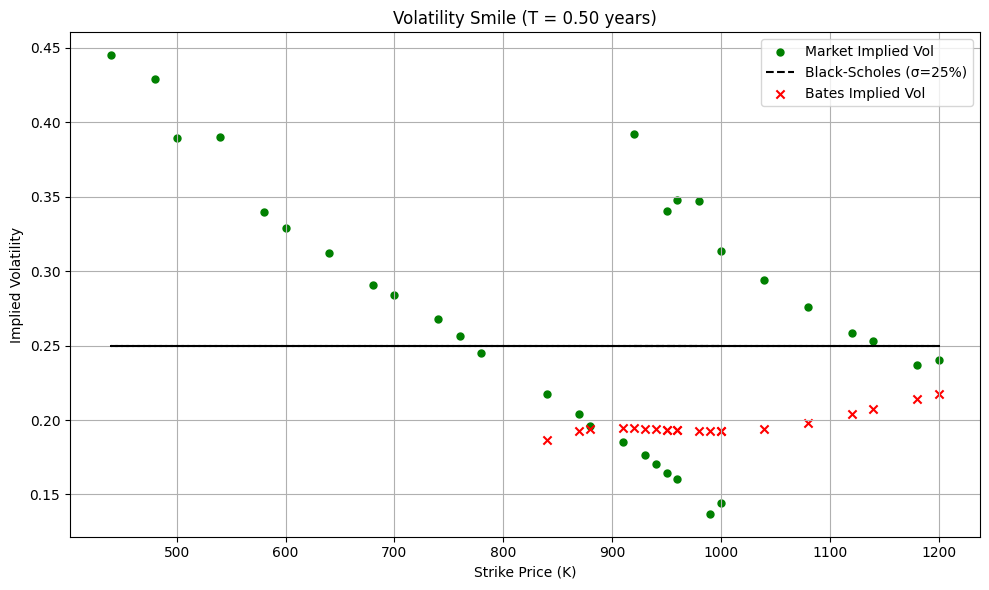

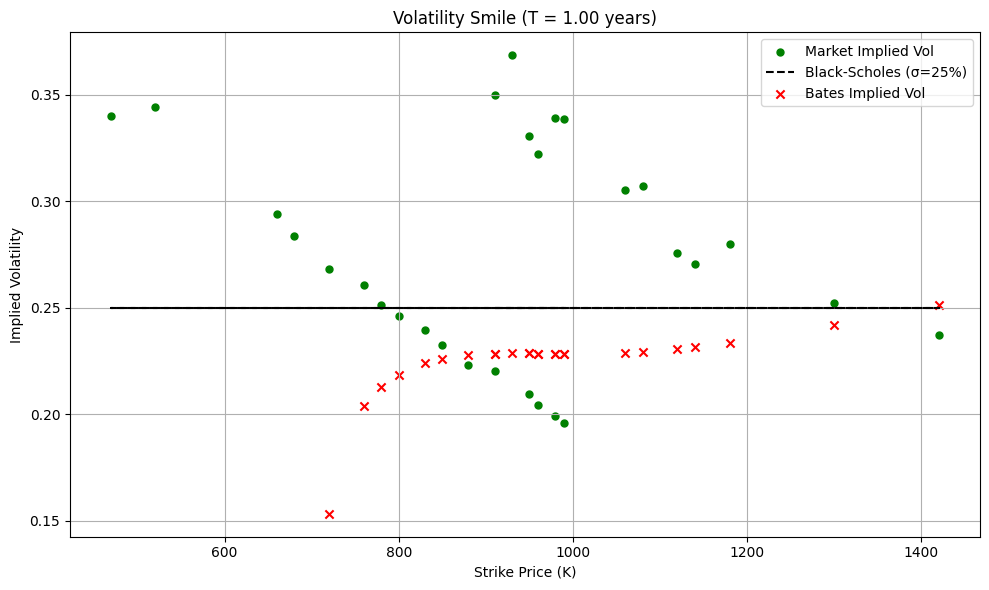

In [19]:
calibrator.plot_implied_volatility_smile_comparison(clean_otm_options_df)

### Exotic Product Pricing

#### Volatility Truncation Method: `max(0, ·)`

To ensure non-negative variance in the Bates model simulation, we use **Euler discretization** with a **"max truncation"** scheme:

\[
v_{t+1} = \max(0, v_t + \text{Euler increment})
\]

##### Justification:
- Respects the financial constraint that **variance cannot be negative**
- Prevents invalid square roots and resulting numerical instability
- Aligns with the **Cox-Ingersoll-Ross (CIR)** process structure in the Heston and Bates models
- Common practice in Monte Carlo option pricing literature (e.g., Andersen & Andreasen)

This method is simple, stable, and appropriate for structured product pricing where high-frequency volatility behavior is not the primary focus.

In [ ]:
from exotic_price_and_hedge import MonteCarloExoticPricer

# Calibrated Bates parameters
v0, kappa, theta, sigma, rho, lamb, mu_j, sigma_j = result["optimized_params"]

S0 = S0
r = 0.04
maturities = [0.25, 0.5, 1.0]
bonus_levels = [900, 925, 950, 975, 1000]
barrier_levels = [650, 700, 750, 800]

# Store results
pricing_records = []

for T in maturities:
    print(f"\nSimulating paths and pricing for T = {T} years...")
    pricer = MonteCarloExoticPricer(S0, r, T, v0, kappa, theta, sigma, rho, lamb, mu_j, sigma_j)

    for B in bonus_levels:
        for H in barrier_levels:
            price = pricer.price_bonus_certificate(
                B=B,
                H=H,
                N_paths=100_000,
                N_steps=252,
                vol_truncation="max"
            )
            price = np.round(price, 2)
            margin_pct = np.round((price - B) / B * 100, 2)
            margin_usd = np.round(price - B, 2)
            pricing_records.append((T, B, H, price, margin_pct, margin_usd))

# Format into a table for display
df = pd.DataFrame(pricing_records, columns=["T", "B", "H", "Price", "Margin (%)", "Margin (USD)"])
tables = []

for T in maturities:
    sub_df = df[df["T"] == T][["B", "H", "Price", "Margin (%)", "Margin (USD)"]].reset_index(drop=True)
    sub_df.columns = pd.MultiIndex.from_product([[f"T = {T}"], sub_df.columns])
    tables.append(sub_df)

full_table = pd.concat(tables, axis=1)

# Display nicely
display(full_table)

In [ ]:
# Bonus certificate pricing, chosen (B=1000, H=750, T=0.25)
T = 0.25
pricer = MonteCarloExoticPricer(S0, r, T, v0, kappa, theta, sigma, rho, lamb, mu_j, sigma_j)

bonus_level = 975
barrier_level = 700

price_bc = pricer.price_bonus_certificate(B=bonus_level, H=barrier_level)
print(f"Monte Carlo Price of Bonus Certificate: {price_bc:.2f} USD")

In [ ]:
# Simulate paths using "max" truncation
paths = pricer.simulate_paths(N_paths=100000, N_steps=252, vol_truncation="max")

# Plot simulated paths
pricer.plot_simulated_paths(paths, n_paths_plot=500)

# Compute per-path payoffs
payoffs = pricer.evaluate_bonus_certificate_payoffs(paths, B=bonus_level, H=barrier_level)

# Discounted price (Monte Carlo value)
discounted_price = np.exp(-r * T) * payoffs.mean()
print(f"Fair Value of Bonus Certificate: {discounted_price:.2f} USD")

In [ ]:
# Histogram

plt.figure(figsize=(8, 5))
plt.hist(payoffs, bins=50, color="steelblue", edgecolor="black", alpha=0.7)
plt.axvline(x=1000, color="red", linestyle="--", label="Bonus Level")
plt.axvline(x=payoffs.mean(), color="black", linestyle="--", label="Expected Payoff")
plt.title("Distribution of Bonus Certificate Payoffs")
plt.xlabel("Payoff")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
sell_price = discounted_price * 1.02  # offered to investor
cost_price = discounted_price
margin = sell_price - cost_price
print("Sell Price:",sell_price)
print("Cost Price (Model):", cost_price)
print(f"Bank's expected margin: {margin:.2f} USD")

In [ ]:
from exotic_price_and_hedge import HedgingStrategy

T = 0.25
bonus_level = 975
barrier_level = 700
pricer = MonteCarloExoticPricer(S0, r, T, v0, kappa, theta, sigma, rho, lamb, mu_j, sigma_j)

hedger = HedgingStrategy(
    pricer=pricer,   # calibrated MonteCarloExoticPricer
    B=bonus_level,
    H=barrier_level,
    T=T,
    notional=1_000_000
)

delta_0 = hedger.compute_delta()
shares = hedger.compute_hedge_position(delta_0)

print(f"Delta at t=0: {delta_0:.4f}")
print(f"Hedge position: {shares:.0f}")